## MLOEps Coding Project
By Amy Li

### Introduction

The data used in this project is Loan Defaulter from Kaggle: https://www.kaggle.com/datasets/gauravduttakiit/loan-defaulter\
The dataset contains: \
Application Data: Current loan applications, with label column indicating a loan default.\
Previous Application Data: All historical loan applications. Each client may match to multiple previous loan applications. Contains information on whether the previous loan was approved or not.\
Column Description: Feature explanations.

The purpose of analyzing and building a model for the Loan Defaulter dataset is to predict the default probability of a new loan application to reduce financial risk. The following steps are taken in this exploratory data analysis notebook:
1. Setup
2. Import and View Data
3. Data Quality Check\
    3.1 Exploratory Analysis\
    3.2 Null Values\
    3.3 Categorical Encoding
4. Feature Engineering\
    4.1 Create Historical Features\
    4.2 Join Historical Features\
    4.3 Feature Selection
5. Split Data

For simplicity sake and to reduce required compute, feature engineering and processing are kept to a minimum to keep a reasonable number of features for model training. 


### 1. Setup

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import os

### 2. Import and View Data

Application data: Contains current loan applications, primary key similar to client number and can be matched to previous loan applications. Contains loan default in 'TARGET'.\
Previous application data: Contains all historical loan applications. Each client number can match to multiple loan applications. Contains historical information on whether the loan was approved or not. \
Column description: Contains feature explanations.

Goal: Predict a client's loan application's probability of defaulting/not able to pay back on time. 



In [8]:
py_dir_path = os.path.abspath("")
dir_path = os.path.join(py_dir_path, 'data')
app_data = pd.read_csv(os.path.join(dir_path, 'application_data.csv'))
columns_desc = pd.read_csv(os.path.join(dir_path,'columns_description.csv'))
prev_app_data = pd.read_csv(os.path.join(dir_path,'previous_application.csv'))

In [6]:
# Obtain input data dimensions
print('Application data shape: ', app_data.shape)
print('Previous application data shape: ', prev_app_data.shape)
print('Column description shape: ', columns_desc.shape)

Application data shape:  (307511, 122)
Previous application data shape:  (1670214, 37)
Column description shape:  (160, 5)


In [7]:
# View data
pd.set_option("display.max_rows", None, "display.max_columns", None)
print('Application data')
display(app_data.head(10))

print('Previous application data')
display(prev_app_data.head(10))

print('Column description')
display(columns_desc.head(10))

Application data


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Previous application data


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
5,1383531,199383,Cash loans,23703.930,315000.0,340573.5,NaN,315000.0,SATURDAY,8,Y,1,NaN,NaN,NaN,Everyday expenses,Approved,-684,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,18.0,low_normal,Cash X-Sell: low,365243.0,-654.0,-144.0,-144.0,-137.0,1.0
6,2315218,175704,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Canceled,-14,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
7,1656711,296299,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Canceled,-21,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
8,2367563,342292,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,15,Y,1,NaN,NaN,NaN,XNA,Canceled,-386,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
9,2579447,334349,Cash loans,NaN,0.0,0.0,NaN,NaN,SATURDAY,15,Y,1,NaN,NaN,NaN,XNA,Canceled,-57,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN


Column description


,Unnamed: 0,Table,Row,Description,Special
0,1,application_data,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_data,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_data,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_data,CODE_GENDER,Gender of the client,NaN
4,7,application_data,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_data,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_data,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_data,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_data,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_data,AMT_ANNUITY,Loan annuity,NaN


### 3. Data Quality Check

No duplicates in application data primary key (client number).


In [16]:
# Unique values in primary key
print('Total primary keys: ', app_data.shape[0])
print('Unique primary keys: ', app_data['SK_ID_CURR'].nunique())

# Unique values in target label
print('Unique target labels: ', app_data['TARGET'].unique())


Total primary keys:  307511
Unique primary keys:  307511
Unique target labels:  [1 0]
Percentage of positive labels: 8.07


#### 3.1 Exploratory Analysis

Percentage of positive labels is 8.07% - able to balance using tree-based models.
* Loan type is unevenly distributed between Cash and Revolving - however, due to previous application data having more than these two types, will consider all loan types in training.
* No significant variance in loan amount, income, available credit, and goods amount with defaulting or not. 
* Pair plots of 'Amount' features show few minimal outliers between repayers and defaulters.
* Redundant  environment/land/housing variables that are highly correlated.



In [172]:
# Target percentage
print('Percentage of positive labels:', round(app_data['TARGET'].sum()*100/app_data.shape[0],2))

Percentage of positive labels: 8.07


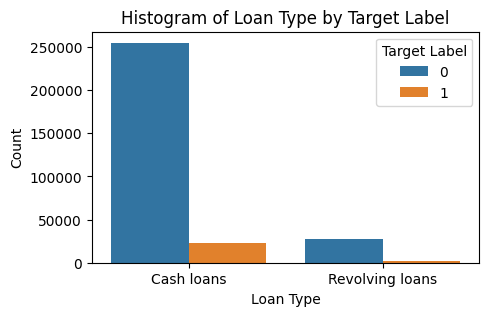

In [175]:
# Bar chart for type of loan
plt.figure(figsize=(5, 3))
sns.countplot(x='NAME_CONTRACT_TYPE', hue='TARGET', data=app_data)
plt.title('Histogram of Loan Type by Target Label')
plt.xlabel('Loan Type')
plt.ylabel('Count')
plt.legend(title='Target Label', loc='upper right')
plt.show()

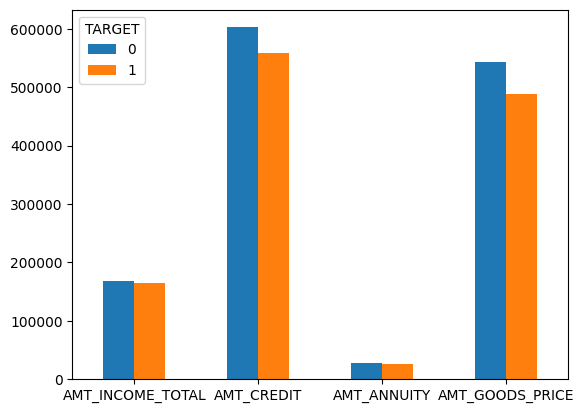

In [202]:
# Mean bar plots for 'amount' features
means = app_data[['TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']].groupby('TARGET').mean()
means_T = means.T
ax = means_T.plot.bar(rot=0)

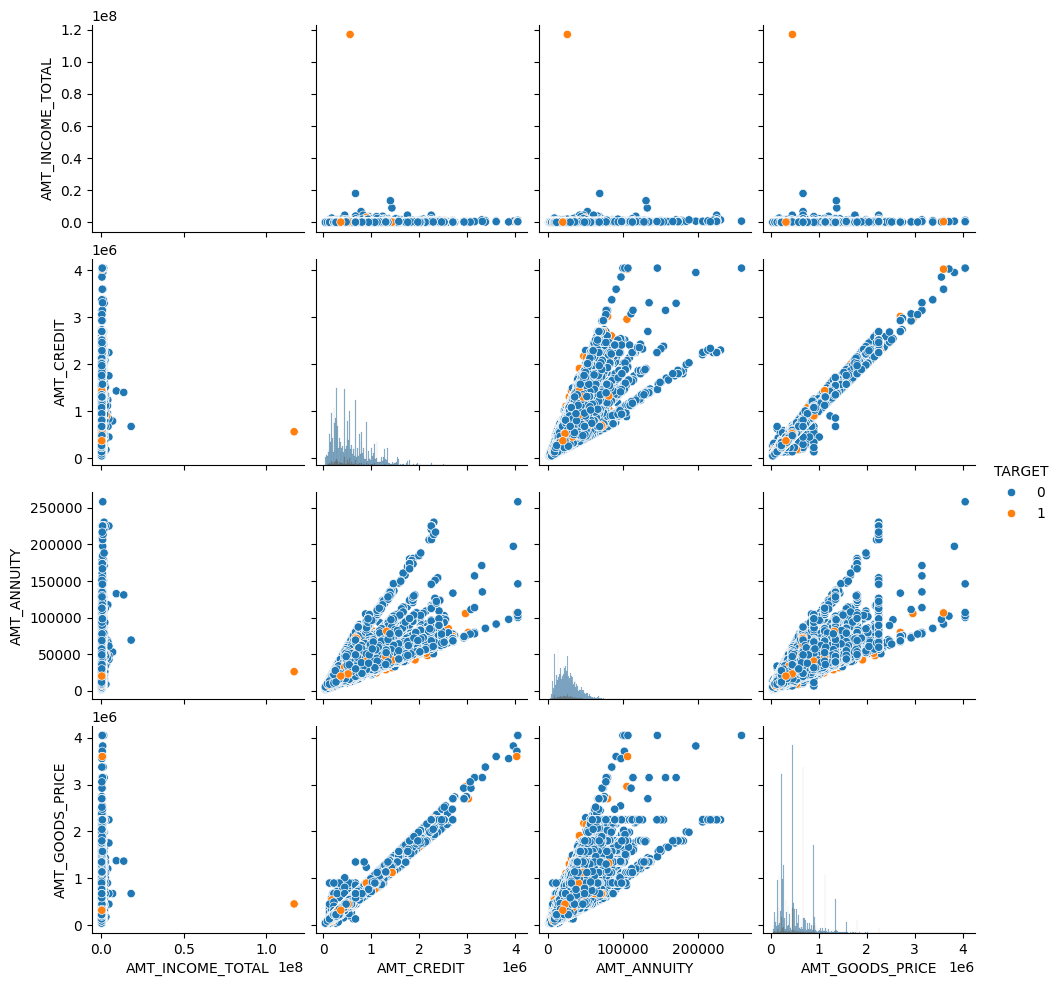

In [14]:
# Pairplots for 'amount' features
amt = app_data[[ 'AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY', 'AMT_GOODS_PRICE',"TARGET"]]
amt = amt[(amt["AMT_GOODS_PRICE"].notnull()) & (amt["AMT_ANNUITY"].notnull())]
sns.pairplot(amt,hue="TARGET",diag_kind="hist")
plt.show()

In [12]:
df_repayer = app_data[app_data['TARGET'] == 0].select_dtypes(include=['int64', 'float64'])
df_defaulter = app_data[app_data['TARGET'] == 1].select_dtypes(include=['int64', 'float64'])

# Compute the correlation matrix for repayers
corr_matrix = df_repayer.corr()
corr_pairs = corr_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs != 1]
corr_pairs = corr_pairs.abs()
corr_pairs = corr_pairs.sort_values(ascending=False)

corr_pairs.head(50)

DAYS_EMPLOYED                 FLAG_EMP_PHONE                  0.999758
FLAG_EMP_PHONE                DAYS_EMPLOYED                   0.999758
YEARS_BUILD_AVG               YEARS_BUILD_MEDI                0.998522
YEARS_BUILD_MEDI              YEARS_BUILD_AVG                 0.998522
OBS_60_CNT_SOCIAL_CIRCLE      OBS_30_CNT_SOCIAL_CIRCLE        0.998508
OBS_30_CNT_SOCIAL_CIRCLE      OBS_60_CNT_SOCIAL_CIRCLE        0.998508
FLOORSMIN_MEDI                FLOORSMIN_AVG                   0.997202
FLOORSMIN_AVG                 FLOORSMIN_MEDI                  0.997202
FLOORSMAX_MEDI                FLOORSMAX_AVG                   0.997018
FLOORSMAX_AVG                 FLOORSMAX_MEDI                  0.997018
ENTRANCES_AVG                 ENTRANCES_MEDI                  0.996899
ENTRANCES_MEDI                ENTRANCES_AVG                   0.996899
ELEVATORS_MEDI                ELEVATORS_AVG                   0.996161
ELEVATORS_AVG                 ELEVATORS_MEDI                  0.996161
COMMON

In [11]:
# Compute the correlation for defaulters
corr_matrix = df_defaulter.corr()
corr_pairs = corr_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs != 1]
corr_pairs = corr_pairs.abs()
corr_pairs = corr_pairs.sort_values(ascending=False)

corr_pairs.head(50)

DAYS_EMPLOYED                 FLAG_EMP_PHONE                  0.999702
FLAG_EMP_PHONE                DAYS_EMPLOYED                   0.999702
OBS_60_CNT_SOCIAL_CIRCLE      OBS_30_CNT_SOCIAL_CIRCLE        0.998269
OBS_30_CNT_SOCIAL_CIRCLE      OBS_60_CNT_SOCIAL_CIRCLE        0.998269
BASEMENTAREA_AVG              BASEMENTAREA_MEDI               0.998250
BASEMENTAREA_MEDI             BASEMENTAREA_AVG                0.998250
COMMONAREA_MEDI               COMMONAREA_AVG                  0.998107
COMMONAREA_AVG                COMMONAREA_MEDI                 0.998107
YEARS_BUILD_AVG               YEARS_BUILD_MEDI                0.998100
YEARS_BUILD_MEDI              YEARS_BUILD_AVG                 0.998100
NONLIVINGAPARTMENTS_AVG       NONLIVINGAPARTMENTS_MEDI        0.998075
NONLIVINGAPARTMENTS_MEDI      NONLIVINGAPARTMENTS_AVG         0.998075
FLOORSMIN_AVG                 FLOORSMIN_MEDI                  0.997825
FLOORSMIN_MEDI                FLOORSMIN_AVG                   0.997825
LIVING

#### 3.2 Null Values

* Checked for features with more than 50% null values. Mostly on environmental variables' average, mean, and mode. Removed mean and mode features and kept features with average to be filled with 0.\
* Checked for max and min values and found negative 'date since' variables - replaced by absolute values.
* Null values in features in this dataset have no explicit meaning. Can be filled with 0 if model algorithms cannot handle null values. 

In [19]:
# Check for percentage of null values
round(app_data.isnull().sum()*100/app_data.shape[0],2)

SK_ID_CURR                       0.00
TARGET                           0.00
NAME_CONTRACT_TYPE               0.00
CODE_GENDER                      0.00
FLAG_OWN_CAR                     0.00
FLAG_OWN_REALTY                  0.00
CNT_CHILDREN                     0.00
AMT_INCOME_TOTAL                 0.00
AMT_CREDIT                       0.00
AMT_ANNUITY                      0.00
AMT_GOODS_PRICE                  0.09
NAME_TYPE_SUITE                  0.42
NAME_INCOME_TYPE                 0.00
NAME_EDUCATION_TYPE              0.00
NAME_FAMILY_STATUS               0.00
NAME_HOUSING_TYPE                0.00
REGION_POPULATION_RELATIVE       0.00
DAYS_BIRTH                       0.00
DAYS_EMPLOYED                    0.00
DAYS_REGISTRATION                0.00
DAYS_ID_PUBLISH                  0.00
OWN_CAR_AGE                     65.99
FLAG_MOBIL                       0.00
FLAG_EMP_PHONE                   0.00
FLAG_WORK_PHONE                  0.00
FLAG_CONT_MOBILE                 0.00
FLAG_PHONE  

In [25]:
# List out columns with more than 50% null to check their description
null_columns = app_data.isnull().sum()[app_data.isnull().sum() > app_data.shape[0]*0.5 ].index.tolist()
filtered_descriptions_df = columns_desc[columns_desc['Row'].isin(null_columns)]

pd.set_option('display.max_colwidth', None)
filtered_descriptions_df

,Unnamed: 0,Table,Row,Description,Special
21,24,application_data,OWN_CAR_AGE,Age of client's car,NaN
41,44,application_data,EXT_SOURCE_1,Normalized score from external data source,normalized
44,47,application_data,APARTMENTS_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
45,48,application_data,BASEMENTAREA_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
47,50,application_data,YEARS_BUILD_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
48,51,application_data,COMMONAREA_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
49,52,application_data,ELEVATORS_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
50,53,application_data,ENTRANCES_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
52,55,application_data,FLOORSMIN_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized
53,56,application_data,LANDAREA_AVG,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized


In [84]:
# Drop columns other than average values
avg_columns = list(filter(lambda col: col.endswith('_AVG'), null_columns))
drop_columns = list(set(null_columns)-set(avg_columns))
print('Columns to drop: ', drop_columns)

df = app_data.drop(columns=drop_columns)
print('Data dimensions after dropping: ', df.shape)

Columns to drop:  ['WALLSMATERIAL_MODE', 'YEARS_BUILD_MODE', 'LANDAREA_MEDI', 'YEARS_BUILD_MEDI', 'LIVINGAREA_MODE', 'BASEMENTAREA_MEDI', 'NONLIVINGAREA_MODE', 'COMMONAREA_MEDI', 'FONDKAPREMONT_MODE', 'FLOORSMIN_MEDI', 'ELEVATORS_MEDI', 'HOUSETYPE_MODE', 'ENTRANCES_MODE', 'ENTRANCES_MEDI', 'FLOORSMIN_MODE', 'LIVINGAREA_MEDI', 'BASEMENTAREA_MODE', 'EXT_SOURCE_1', 'NONLIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MEDI', 'APARTMENTS_MEDI', 'ELEVATORS_MODE', 'OWN_CAR_AGE', 'LIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MEDI', 'APARTMENTS_MODE', 'COMMONAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'LANDAREA_MODE']
Data dimensions after dropping:  (307511, 93)


In [46]:
# Check max and min values
max_values = df.select_dtypes(include=['int64', 'float64']).max()
min_values = df.select_dtypes(include=['int64', 'float64']).min()
print(max_values)
print(min_values)

SK_ID_CURR                      4.562550e+05
TARGET                          1.000000e+00
CNT_CHILDREN                    1.900000e+01
AMT_INCOME_TOTAL                1.170000e+08
AMT_CREDIT                      4.050000e+06
AMT_ANNUITY                     2.580255e+05
AMT_GOODS_PRICE                 4.050000e+06
REGION_POPULATION_RELATIVE      7.250800e-02
DAYS_BIRTH                     -7.489000e+03
DAYS_EMPLOYED                   3.652430e+05
DAYS_REGISTRATION               0.000000e+00
DAYS_ID_PUBLISH                 0.000000e+00
FLAG_MOBIL                      1.000000e+00
FLAG_EMP_PHONE                  1.000000e+00
FLAG_WORK_PHONE                 1.000000e+00
FLAG_CONT_MOBILE                1.000000e+00
FLAG_PHONE                      1.000000e+00
FLAG_EMAIL                      1.000000e+00
CNT_FAM_MEMBERS                 2.000000e+01
REGION_RATING_CLIENT            3.000000e+00
REGION_RATING_CLIENT_W_CITY     3.000000e+00
HOUR_APPR_PROCESS_START         2.300000e+01
REG_REGION

In [85]:
# Convert negative 'days since' columns
df['DAYS_BIRTH'] = abs(df['DAYS_BIRTH'])
df['DAYS_EMPLOYED'] = abs(df['DAYS_EMPLOYED'])
df['DAYS_ID_PUBLISH'] = abs(df['DAYS_ID_PUBLISH'])
df['DAYS_REGISTRATION'] = abs(df['DAYS_REGISTRATION'])
df['DAYS_LAST_PHONE_CHANGE'] = abs(df['DAYS_LAST_PHONE_CHANGE'])

#### 3.3 Categorical encoding

* Checked for categorical columns.
* Grouped redundant  categories into simpler ones.
* Label-encoded categorical columns.

In [51]:
# Visualize categorical features
categorical_columns = df.select_dtypes(include=['object', 'category'])

for column in categorical_columns.columns:
    print(f"\nValue counts for column '{column}':")
    counts = df.groupby(column).size()
    print(counts)


Value counts for column 'NAME_CONTRACT_TYPE':
NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
dtype: int64

Value counts for column 'CODE_GENDER':
CODE_GENDER
F      202448
M      105059
XNA         4
dtype: int64

Value counts for column 'FLAG_OWN_CAR':
FLAG_OWN_CAR
N    202924
Y    104587
dtype: int64

Value counts for column 'FLAG_OWN_REALTY':
FLAG_OWN_REALTY
N     94199
Y    213312
dtype: int64

Value counts for column 'NAME_TYPE_SUITE':
NAME_TYPE_SUITE
Children             3267
Family              40149
Group of people       271
Other_A               866
Other_B              1770
Spouse, partner     11370
Unaccompanied      248526
dtype: int64

Value counts for column 'NAME_INCOME_TYPE':
NAME_INCOME_TYPE
Businessman                 10
Commercial associate     71617
Maternity leave              5
Pensioner                55362
State servant            21703
Student                     18
Unemployed                  22
Working                 158774
dtype: in

In [86]:
# Drop meaningless date feature: WEEKDAY_APPR_PROCESS_START
df = df.drop(columns='WEEKDAY_APPR_PROCESS_START')

In [87]:
# Combine excess categories for: ORGANIZATION_TYPE, OCCUPATION_TYPE
occ_type_dict = {
    'Accountants': 'Finance',
    'Cleaning staff': 'Maintenance',
    'Cooking staff': 'Hospitality',
    'Core staff': 'Administrative',
    'Drivers': 'Transportation',
    'HR staff': 'Human Resources',
    'High skill tech staff': 'Technology',
    'IT staff': 'Technology',
    'Laborers': 'Labor',
    'Low-skill Laborers': 'Labor',
    'Managers': 'Management',
    'Medicine staff': 'Healthcare',
    'Private service staff': 'Hospitality',
    'Realty agents': 'Real Estate',
    'Sales staff': 'Sales',
    'Secretaries': 'Administrative',
    'Security staff': 'Security',
    'Waiters/barmen staff': 'Hospitality'
}

org_type_dict = {
    'Advertising': 'Marketing',
    'Agriculture': 'Agriculture',
    'Bank': 'Finance',
    'Business Entity Type 1': 'Business',
    'Business Entity Type 2': 'Business',
    'Business Entity Type 3': 'Business',
    'Cleaning': 'Maintenance',
    'Construction': 'Construction',
    'Culture': 'Culture',
    'Electricity': 'Utilities',
    'Emergency': 'Emergency Services',
    'Government': 'Government',
    'Hotel': 'Hospitality',
    'Housing': 'Housing',
    'Industry: type 1': 'Industry',
    'Industry: type 10': 'Industry',
    'Industry: type 11': 'Industry',
    'Industry: type 12': 'Industry',
    'Industry: type 13': 'Industry',
    'Industry: type 2': 'Industry',
    'Industry: type 3': 'Industry',
    'Industry: type 4': 'Industry',
    'Industry: type 5': 'Industry',
    'Industry: type 6': 'Industry',
    'Industry: type 7': 'Industry',
    'Industry: type 8': 'Industry',
    'Industry: type 9': 'Industry',
    'Insurance': 'Finance',
    'Kindergarten': 'Education',
    'Legal Services': 'Legal',
    'Medicine': 'Healthcare',
    'Military': 'Government',
    'Mobile': 'Telecom',
    'Other': 'Miscellaneous',
    'Police': 'Public Safety',
    'Postal': 'Public Services',
    'Realtor': 'Real Estate',
    'Religion': 'Religion',
    'Restaurant': 'Hospitality',
    'School': 'Education',
    'Security': 'Security',
    'Security Ministries': 'Security',
    'Self-employed': 'Business',
    'Services': 'Services',
    'Telecom': 'Telecom',
    'Trade: type 1': 'Trade',
    'Trade: type 2': 'Trade',
    'Trade: type 3': 'Trade',
    'Trade: type 4': 'Trade',
    'Trade: type 5': 'Trade',
    'Trade: type 6': 'Trade',
    'Trade: type 7': 'Trade',
    'Transport: type 1': 'Transport',
    'Transport: type 2': 'Transport',
    'Transport: type 3': 'Transport',
    'Transport: type 4': 'Transport',
    'University': 'Education',
    'XNA': 'Unknown'
}

In [88]:
# Map new simplified categories
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].map(org_type_dict)
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].map(occ_type_dict)

print('Mapped organization type: ', df['ORGANIZATION_TYPE'].unique())
print('Mapped occupation type: ', df['OCCUPATION_TYPE'].unique())

Mapped organization type:  ['Business' 'Education' 'Government' 'Religion' 'Miscellaneous' 'Unknown'
 'Utilities' 'Healthcare' 'Transport' 'Construction' 'Housing' 'Trade'
 'Industry' 'Services' 'Security' 'Emergency Services' 'Public Safety'
 'Public Services' 'Agriculture' 'Hospitality' 'Culture' 'Finance'
 'Telecom' 'Legal' 'Marketing' 'Maintenance' 'Real Estate']
Mapped occupation type:  ['Labor' 'Administrative' 'Finance' 'Management' nan 'Transportation'
 'Sales' 'Maintenance' 'Hospitality' 'Healthcare' 'Security' 'Technology'
 'Real Estate' 'Human Resources']


In [93]:
# Label encode categorical columns
label_encoders = {col: LabelEncoder() for col in df.select_dtypes(include=['object', 'category'])}

for col, encoder in label_encoders.items():
    df[col] = encoder.fit_transform(df[col])

### 4. Feature Engineering

Goal: Build previous loan applications as historical features into current application data and perform feature selection.

Historical application IDs are unique, with one client possibly matching to multiple application IDs. 

In [102]:
# Engineer previous application history as an input feature for current application

# Check for unique loan IDs in previous application dataset
print('Unique current primary keys: ', app_data['SK_ID_CURR'].nunique())
print('Total primary keys: ', prev_app_data.shape[0])
print('Unique current loan IDs in historical data: ', prev_app_data['SK_ID_CURR'].nunique())
print('Unique previous loan IDs in historical data: ', prev_app_data['SK_ID_PREV'].nunique())

Unique current loan IDs:  307511
Total primary keys:  1670214
Unique current loan IDs in historical data:  338857
Unique previous loan IDs in historical data:  1670214


#### 4.1 Create Historical Features on Previous Application Data

* Kept only clients who are in current application data.
* Checked for historical loan status - encoded feature to 1 - 'Approved' and 0 - for all other status.
* Created features based on number of applications applied during time periods; spanning up to 10 years.
* Created features on number of approved loan applications during each of the time periods.

For simplicity sake, only created historical features on number of applications and approval status. Ideally could use more information in previous loan application data to obtain more meaningful features. 


In [103]:
# Keep only the primary keys that exists in current application data
prev_app_cleaned = prev_app_data.merge(app_data[['SK_ID_CURR']], on='SK_ID_CURR', how='inner')

In [106]:
# Check unique values
print('Total primary keys: ', prev_app_cleaned.shape[0])
print('Unique current loan IDs in historical data: ', prev_app_cleaned['SK_ID_CURR'].nunique())
print('Unique previous loan IDs in historical data: ', prev_app_cleaned['SK_ID_PREV'].nunique())

Total primary keys:  1413701
Unique current loan IDs in historical data:  291057
Unique previous loan IDs in historical data:  1413701


In [108]:
prev_app_cleaned.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
# Visualize categorical features
categorical_columns = prev_app_cleaned.select_dtypes(include=['object', 'category'])

for column in categorical_columns.columns:
    print(f"\nValue counts for column '{column}':")
    counts = prev_app_cleaned.groupby(column).size()
    print(counts)


Value counts for column 'NAME_CONTRACT_TYPE':
NAME_CONTRACT_TYPE
Cash loans         626764
Consumer loans     625256
Revolving loans    161368
XNA                   313
dtype: int64

Value counts for column 'WEEKDAY_APPR_PROCESS_START':
WEEKDAY_APPR_PROCESS_START
FRIDAY       213373
MONDAY       214509
SATURDAY     204159
SUNDAY       140078
THURSDAY     211005
TUESDAY      215058
WEDNESDAY    215519
dtype: int64

Value counts for column 'FLAG_LAST_APPL_PER_CONTRACT':
FLAG_LAST_APPL_PER_CONTRACT
N       7314
Y    1406387
dtype: int64

Value counts for column 'NAME_CASH_LOAN_PURPOSE':
NAME_CASH_LOAN_PURPOSE
Building a house or an annex          2344
Business development                   359
Buying a garage                        116
Buying a holiday home / land           463
Buying a home                          701
Buying a new car                       886
Buying a used car                     2469
Car repairs                            691
Education                             133

C:\Users\Yixin Xiao\AppData\Local\Temp\ipykernel_19420\972434298.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = prev_app_cleaned.groupby(column).size()


In [120]:
# Create label encoding for contract status - only keep 'Approved'
status = {
    'Approved': 1,
    'Canceled': 0,
    'Refused': 0,
    'Unused offer': 0
}

# Apply the mapping to the DataFrame
prev_app_cleaned['NAME_CONTRACT_STATUS'] = prev_app_cleaned['NAME_CONTRACT_STATUS'].map(status)

In [121]:
# Convert negative 'days since' columns
prev_app_cleaned['DAYS_DECISION'] = abs(prev_app_cleaned['DAYS_DECISION'])
prev_app_cleaned['DAYS_FIRST_DUE'] = abs(prev_app_cleaned['DAYS_FIRST_DUE'])
prev_app_cleaned['DAYS_LAST_DUE_1ST_VERSION'] = abs(prev_app_cleaned['DAYS_LAST_DUE_1ST_VERSION'])
prev_app_cleaned['DAYS_LAST_DUE'] = abs(prev_app_cleaned['DAYS_LAST_DUE'])
prev_app_cleaned['DAYS_TERMINATION'] = abs(prev_app_cleaned['DAYS_TERMINATION'])

prev_app_cleaned.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CONTRACT_STATUS,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.413701e+06,1.413701e+06,1.106483e+06,1.413701e+06,1.413700e+06,6.641610e+05,1.094176e+06,1.413701e+06,1.413701e+06,664161.000000,4791.000000,4791.000000,1.413701e+06,1.413701e+06,1.413701e+06,1.106488e+06,852595.000000,852595.000000,852595.000000,852595.000000,852595.000000,852595.000000
mean,1.922744e+06,2.784813e+05,1.583718e+04,1.752436e+05,1.963541e+05,6.655317e+03,2.264512e+05,1.247893e+01,9.964321e-01,0.080175,0.189436,0.771284,6.267938e-01,8.803670e+02,3.149878e+02,1.605194e+01,342257.656710,15609.207087,34669.503624,78233.262039,83862.070031,0.330572
std,5.327153e+05,1.028118e+05,1.472491e+04,2.936222e+05,3.194813e+05,2.062030e+04,3.159376e+05,3.331474e+00,5.962560e-02,0.107784,0.090849,0.100644,4.836564e-01,7.835402e+02,7.695082e+03,1.456675e+01,88832.266598,71218.272352,105714.533099,148891.497683,152718.132212,0.470419
min,1.000001e+06,1.000020e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,0.034781,0.373150,0.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,-2922.000000,2.000000,0.000000,2.000000,2.000000,0.000000
25%,1.461346e+06,1.893640e+05,6.257858e+03,1.975050e+04,2.488050e+04,0.000000e+00,4.982850e+04,1.000000e+01,1.000000e+00,0.000000,0.160716,0.715645,0.000000e+00,2.710000e+02,-1.000000e+00,6.000000e+00,365243.000000,469.000000,256.000000,453.000000,445.000000,0.000000
50%,1.922698e+06,2.789920e+05,1.122376e+04,7.087050e+04,8.059500e+04,1.791000e+03,1.102455e+05,1.200000e+01,1.000000e+00,0.062489,0.189136,0.835095,1.000000e+00,5.820000e+02,4.000000e+00,1.200000e+01,365243.000000,916.000000,745.000000,1156.000000,1173.000000,0.000000
75%,2.384012e+06,3.675560e+05,2.042078e+04,1.800000e+05,2.156400e+05,7.695000e+03,2.295000e+05,1.500000e+01,1.000000e+00,0.108912,0.193330,0.852537,1.000000e+00,1.313000e+03,8.500000e+01,2.400000e+01,365243.000000,1828.000000,1730.000000,2413.000000,2504.000000,1.000000
max,2.845381e+06,4.562550e+05,4.180581e+05,5.850000e+06,4.509688e+06,3.060045e+06,5.850000e+06,2.300000e+01,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,2.922000e+03,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


In [148]:
# Create historical features based on application date and approval status
prev_features = prev_app_cleaned[['SK_ID_CURR', 'DAYS_DECISION', 'NAME_CONTRACT_STATUS']]

# Define time periods
bins = [0, 30, 60, 90, 120, 360, 720, 1080, 1800, 3600]
labels = ['0-30 days', '31-60 days', '61-90 days', '91-120 days', '121-360 days', '1-2 years', '2-3 years', '3-5 years', '5-10 years']
prev_features['Time Period'] = pd.cut(prev_features['DAYS_DECISION'], bins=bins, labels=labels, right=True)

# Create an indicator column for applications
prev_features['Application'] = 1

# Create pivot tables to aggregate data by primary key and Time Period for application and approvals
loan_applications_pivot = prev_features.pivot_table(index='SK_ID_CURR', columns='Time Period', values='Application', aggfunc='max', fill_value=0)
loan_defaults_pivot = prev_features.pivot_table(index='SK_ID_CURR', columns='Time Period', values='NAME_CONTRACT_STATUS', aggfunc='max', fill_value=0)

# Flatten the column indexes
loan_applications_pivot.columns = [f'Application {col}' for col in loan_applications_pivot.columns]
loan_defaults_pivot.columns = [f'Approved {col}' for col in loan_defaults_pivot.columns]

# Merge the pivot tables on primary key
combined_data = pd.merge(loan_applications_pivot, loan_defaults_pivot, on='SK_ID_CURR').reset_index()


C:\Users\Yixin Xiao\AppData\Local\Temp\ipykernel_19420\409198607.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prev_features['Time Period'] = pd.cut(prev_features['DAYS_DECISION'], bins=bins, labels=labels, right=True)
C:\Users\Yixin Xiao\AppData\Local\Temp\ipykernel_19420\409198607.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prev_features['Application'] = 1
C:\Users\Yixin Xiao\AppData\Local\Temp\ipykernel_19420\409198607.py:14: FutureWarning: The default value of observed=False is deprecated

In [1]:
# View result
pivot_result = pd.DataFrame(combined_data)
pivot_result.head(5)

NameError: name 'pd' is not defined

In [150]:
# Check unique primary key counts
pivot_result['SK_ID_CURR'].nunique()

291057

#### 4.2 Join Historical Features

* Joined historical features to current application data.

In [152]:
# Left join on primary key
df_final = pd.merge(df, pivot_result, on='SK_ID_CURR', how='left')
df_final.head()

In [154]:
# Check final dataset dimension
df_final.shape

(307511, 110)

#### 4.3 Feature Selection

* Checked for highly correlated columns.\
* Did not perform other feature selection; for larger feature sets, possibly fit Random Forest model for feature selection. 

In [156]:
# Identify highly correlated features >0.95
corr_matrix = df_final.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print('Highly correlated columns: ', to_drop)

Highly correlated columns:  ['AMT_GOODS_PRICE', 'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT_W_CITY', 'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'OBS_60_CNT_SOCIAL_CIRCLE', 'Approved 2-3 years', 'Approved 3-5 years', 'Approved 5-10 years']


In [158]:
# Drop highly correlated columns
df_reduced = df_final.drop(columns=['AMT_GOODS_PRICE','FLAG_EMP_PHONE','REGION_RATING_CLIENT_W_CITY','YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE','YEARS_BEGINEXPLUATATION_MEDI','FLOORSMAX_MEDI','OBS_60_CNT_SOCIAL_CIRCLE'])

In [159]:
# Check data dimension
df_reduced.shape

(307511, 102)

### 5. Split Data

Split data into train and test sets.

In [162]:
# Split the data into train and test sets
x = df.drop('TARGET', axis=1)
y = df['TARGET']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=12)

In [166]:
print(y_train.sum()*100/x_train.shape[0])
print(y_test.sum()*100/x_test.shape[0])

8.081444505869728
8.038632261840887
